Libraries

In [ ]:
# Algebra
import numpy as np

# Miscellaneous
import pandas as pd
from typing import List, Callable, Dict
from tqdm import tqdm
from pathlib import Path
import shutil
import urllib
import zipfile
import sys
import gensim
import gensim.downloader as gloader
import json

# Tensorflow
import tensorflow as tf
from tensorflow import keras

# Keras
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Dense, Input, TimeDistributed
from keras.layers import LSTM, Bidirectional
from keras.models import Model

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files



##🎈Task 1 - Corpus

First, we download the TreeBank corpus.

In [ ]:
class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)

def download_url(download_path: Path, url: str):
    with DownloadProgressBar(unit='B', unit_scale=True,
                             miniters=1, desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url, filename=download_path, reporthook=t.update_to)


def download_dataset(download_path: Path, url: str):
    print("Downloading dataset...")
    download_url(url=url, download_path=download_path)
    print("Download complete!")

def extract_dataset(download_path: Path, extract_path: Path):
    print("Extracting dataset... (it may take a while...)")
    with zipfile.ZipFile(download_path, 'r') as loaded_zip:
        loaded_zip.extractall(extract_path)
    print("Extraction completed!")

In [ ]:
url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")

if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_zip_path.exists():
    download_dataset(dataset_zip_path, url)

if not dataset_path.exists():
    extract_dataset(dataset_zip_path, dataset_folder)

Current work directory: /content


dependency_treebank.zip: 459kB [00:00, 3.69MB/s]                           

Download complete!
Extracting dataset... (it may take a while...)


Extraction completed!


We inspect one document from the training set.

In [ ]:
file_path = dataset_folder.joinpath(dataset_name, 'wsj_0001.dp')

with file_path.open(mode='r', encoding='utf-8') as text_file:
    text = text_file.read()
    print(text)

Pierre	NNP	2
Vinken	NNP	8
,	,	2
61	CD	5
years	NNS	6
old	JJ	2
,	,	2
will	MD	0
join	VB	8
the	DT	11
board	NN	9
as	IN	9
a	DT	15
nonexecutive	JJ	15
director	NN	12
Nov.	NNP	9
29	CD	16
.	.	8

Mr.	NNP	2
Vinken	NNP	3
is	VBZ	0
chairman	NN	3
of	IN	4
Elsevier	NNP	7
N.V.	NNP	12
,	,	12
the	DT	12
Dutch	NNP	12
publishing	VBG	12
group	NN	5
.	.	3



We then encode the corpus into a Pandas DataFrame, and split it into train (1-100), validation (101-150), and test set (151-199).

In [ ]:
dataframe_rows = []

folder = dataset_folder.joinpath(dataset_name)
for file_path in folder.glob('*.dp'):
    with file_path.open(mode='r', encoding='utf-8') as text_file:
        text = text_file.read()
        lines= text.split('\n')
        word = [line.split('\t')[0] for line in lines if line]
        label = [line.split('\t')[1] for line in lines if line]
        dataframe_row = {
            "word": word,
            "label": label,
        }
        dataframe_rows.append(dataframe_row)

total_df = pd.DataFrame(dataframe_rows)


We take a random document and check that the sentence length is equal to the label length.


In [ ]:
fool_id = np.random.randint(len(total_df))
print('Length of {}th input sequence: {}'.format(fool_id, len(dataframe_rows[fool_id]['word'])))
print('Length of {}th output sequence: {}'.format(fool_id, len(dataframe_rows[fool_id]['label'])))

Length of 134th input sequence: 1887
Length of 134th output sequence: 1887


##🎈Task 2 - Text Encoding

We fix an embedding size - 50 - and retrieve the GloVe embeddings. Other embedding dimensions were tried - 100, 200, and 300. With `most_similar` method we can perform simple operations with embeddings (additions and subtractions), and retrive the most similar term of the resulting embedding.

In [ ]:
EMB_SIZE = 50
emb_model = gloader.load(f'glove-wiki-gigaword-{EMB_SIZE}')

# emb_model.most_similar(positive = ["queen", "man"], negative = ["woman"])
print('there are {} unique words in GloVe'.format(len(emb_model.key_to_index.keys())))

[==================================================] 100.0% 66.0/66.0MB downloaded
there are 400000 unique words in GloVe


We create our vocabulary. It will contain the whole GloVe plus the tokens in our training set.

In [ ]:
glove_tokens = set(emb_model.key_to_index.keys())

train_df = total_df[:100]
train_sentences = train_df['word'].to_list()
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_sentences)
train_tokens = tokenizer.word_index.keys()

union_vocab = list(glove_tokens.union(train_tokens))


In [ ]:
print(f'N. of tokens (words) in Union Vocabulary: {len(union_vocab)}')

N. of tokens (words) in Union Vocabulary: 402094


We tokenize the whole dataset with the newly created vocabulary.

In [ ]:
word_tokenizer = Tokenizer(filters="", lower=False, oov_token='[unk]')
word_tokenizer.fit_on_texts(union_vocab)
words_encoded = word_tokenizer.texts_to_sequences(total_df.word)

len(word_tokenizer.word_index.keys())

402095

Then, we also encode the labels. This is the reference website: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html

We also select the labels we want to compute the metrics on (avoid class symbols and special characters).

In [ ]:
tag_tokenizer = Tokenizer(filters="", lower=False)
tag_tokenizer.fit_on_texts(total_df.label)
labels_encoded = tag_tokenizer.texts_to_sequences(total_df.label)

# these are the tags to evaluate
tags = ['CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNS', 'NNP', 'NNPS', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB' ]
label_ids = [id for label, id in tag_tokenizer.word_index.items() if label in tags]


In [ ]:
NUM_CLASSES = len(tag_tokenizer.word_index) # 45

print('Tags in the dataset:', NUM_CLASSES)
print(tag_tokenizer.word_index)
print()

print('Number of tags to evaluate:', len(label_ids))
print(label_ids)


Tags in the dataset: 45
{'NN': 1, 'IN': 2, 'NNP': 3, 'DT': 4, 'NNS': 5, 'JJ': 6, ',': 7, '.': 8, 'CD': 9, 'VBD': 10, 'RB': 11, 'VB': 12, 'CC': 13, 'TO': 14, 'VBN': 15, 'VBZ': 16, 'PRP': 17, 'VBG': 18, 'VBP': 19, 'MD': 20, 'POS': 21, 'PRP$': 22, '$': 23, '``': 24, "''": 25, ':': 26, 'WDT': 27, 'JJR': 28, 'NNPS': 29, 'WP': 30, 'RP': 31, 'JJS': 32, 'WRB': 33, 'RBR': 34, '-RRB-': 35, '-LRB-': 36, 'EX': 37, 'RBS': 38, 'PDT': 39, '#': 40, 'WP$': 41, 'LS': 42, 'FW': 43, 'UH': 44, 'SYM': 45}

Number of tags to evaluate: 36
[1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 33, 34, 37, 38, 39, 41, 42, 43, 44, 45]


Given a random sample, we get the number of oov (out-of-vocabulary) tokens w.r.t. the sequence length. The oov token has index 1.

In [ ]:
fool_id = np.random.randint(low=100, high=150)
print(f'total tokens in sentence {fool_id}: {sum([1 for token in words_encoded[fool_id]])}')
print(f'oov tokens in sentence {fool_id}: {sum([1 for token in words_encoded[fool_id] if token == 1])}')

total tokens in sentence 108: 25
oov tokens in sentence 108: 2


In [ ]:
fool_id = np.random.randint(len(total_df))

print('** Length **')
print(f'For entry {fool_id} we have {len(words_encoded[fool_id])} words and {len(labels_encoded[fool_id])} labels (must be the same!)')
print()
print()

print('** Raw data point **')
print('-'*42)
print('words: ['+', '.join(total_df.word[fool_id])+']')
print('labels: ['+', '.join(total_df.label[fool_id])+']')
print()
print()

print('** Encoded data point **')
print('-'*42)
print('words: {}'.format(words_encoded[fool_id]))
print('labels: {}'.format(labels_encoded[fool_id]))


** Length **
For entry 85 we have 517 words and 517 labels (must be the same!)


** Raw data point **
------------------------------------------
words: [Sea, Containers, Ltd., said, it, might, increase, the, price, of, its, $, 70-a-share, buy-back, plan, if, pressed, by, Temple, Holdings, Ltd., ,, which, made, an, earlier, tender, offer, for, Sea, Containers, ., Sea, Containers, ,, a, Hamilton, ,, Bermuda-based, shipping, concern, ,, said, Tuesday, that, it, would, sell, $, 1.1, billion, of, assets, and, use, some, of, the, proceeds, to, buy, about, 50, %, of, its, common, shares, for, $, 70, apiece, ., The, move, is, designed, to, ward, off, a, hostile, takeover, attempt, by, two, European, shipping, concerns, ,, Stena, Holding, AG, and, Tiphook, PLC, ., In, May, ,, the, two, companies, ,, through, their, jointly, owned, holding, company, ,, Temple, ,, offered, $, 50, a, share, ,, or, $, 777, million, ,, for, Sea, Containers, ., In, August, ,, Temple, sweetened, the, offer, to, $, 63,

Sanity check. Input/Output sequences must have the same length.

In [ ]:
different_length = [1 if len(w) != len(l) else 0 for w, l in zip(words_encoded, labels_encoded)]
print("{} sentences have different lengths".format(sum(different_length)))

0 sentences have different lengths


We get the shortest and longest sequence and plot the distribution across the dataset.

In [ ]:
seq_length = [len(seq) for seq in words_encoded]
print('Min sequence length: {}, max sequence length: {}.'.format(min(seq_length), max(seq_length)))


Min sequence length: 22, max sequence length: 4534.


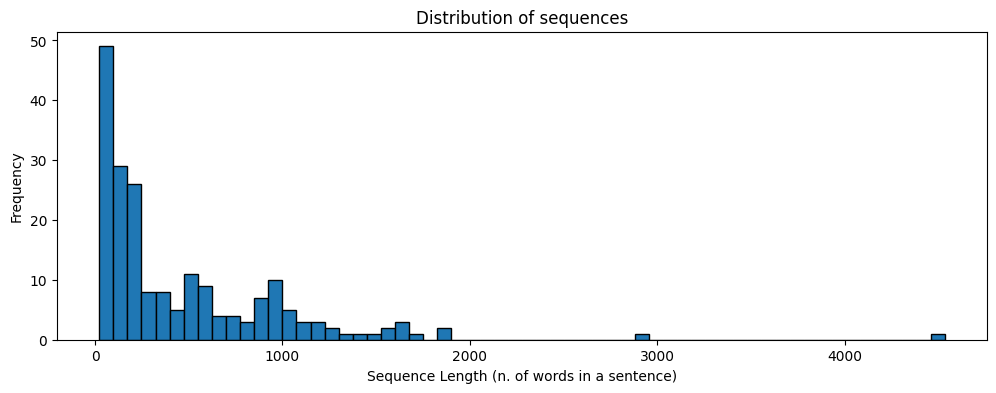

In [ ]:
plt.figure(figsize=[12,4])
plt.hist(seq_length, bins=60, edgecolor='black')
plt.title('Distribution of sequences')
plt.xlabel('Sequence Length (n. of words in a sentence)')
plt.ylabel('Frequency')
plt.show()

We pad the sequences with PAD tokens. We decide the length to truncate, so that if the sequence is longer it gets truncated, otherwise it get padded. We pad on the left, we truncate on the right.

In [ ]:
MAX_SEQ_LENGTH = 300

words_padded = pad_sequences(words_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")
labels_padded = pad_sequences(labels_encoded, maxlen=MAX_SEQ_LENGTH, padding="pre", truncating="post")


Sanity check: print padded sequence - words and labels.

In [ ]:
fool_id = np.random.randint(total_df.shape[0])
print(f'Word and label sequences for sample {fool_id}\n')
print(words_padded[fool_id])
print('-'*42)
print(labels_padded[fool_id])

Word and label sequences for sample 136

[     0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0 351382 352347 101925 245653 368354
 190704 400446 187650 244989 199847 352347   3085  47344 364899 276029
 289666 184830 317853 378064 215296 182640 288559  27841 297602 127179
 397316 123634 305991 303770 259355  32239 104129  72989 289666 199847
 187650 182640 199847  67563  92908  84120 246794 379732 364328 270364
 216298 352347 391702 169732 364899 199847 276029 148718 237754 199847
 352347 378234  36776 217519 145055 

We plot the distribution of the tags in the 3 splits.

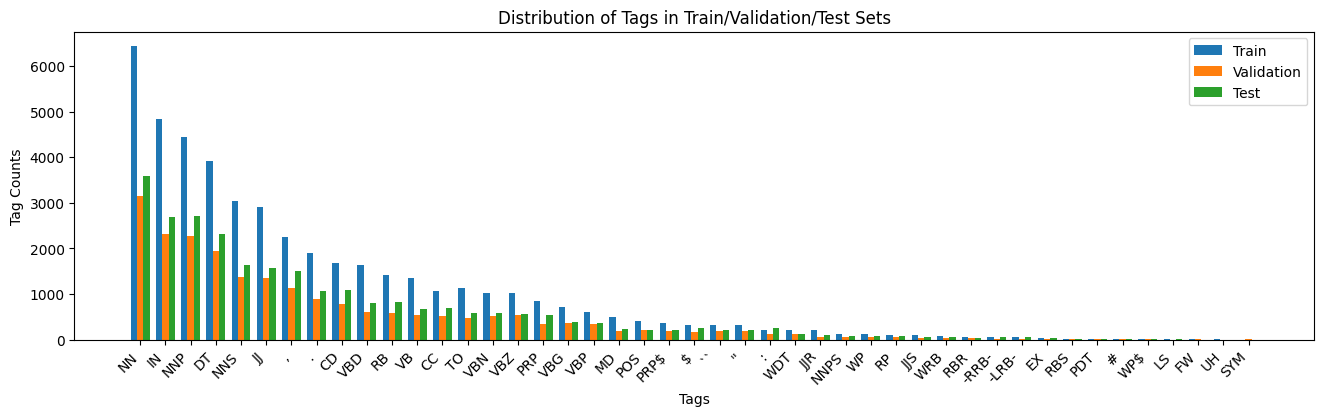

In [ ]:
train_tags = []
val_tags = []
test_tags = []

for tags in labels_encoded[:100]:
  train_tags += tags
for tags in labels_encoded[100:150]:
  val_tags += tags
for tags in labels_encoded[150:]:
  test_tags += tags

# collecting all the unique tags - ie [1, 2, 3, ..., 45]
all_tags = np.unique(np.concatenate([train_tags, val_tags, test_tags]))

# count occurrences of each tag in each set
train_tag_counts = [train_tags.count(tag) for tag in all_tags]
val_tag_counts = [val_tags.count(tag) for tag in all_tags]
test_tag_counts = [test_tags.count(tag) for tag in all_tags]

# Plotting a bar chart
fig, ax = plt.subplots(figsize=(16, 4))
bar_width = 0.25
index = np.arange(len(all_tags))

bar1 = ax.bar(index - bar_width, train_tag_counts, bar_width, label='Train')
bar2 = ax.bar(index, val_tag_counts, bar_width, label='Validation')
bar3 = ax.bar(index + bar_width, test_tag_counts, bar_width, label='Test')

ax.set_xlabel('Tags')
ax.set_ylabel('Tag Counts')
ax.set_title('Distribution of Tags in Train/Validation/Test Sets')
ax.set_xticks(index)
ax.set_xticklabels(tag_tokenizer.word_index.keys(), rotation=45, ha='right')
ax.legend()

plt.show()

Collect the training data and the vocabulary into handy variables.

In [ ]:
X, Y = words_padded, labels_padded

word_to_idx = word_tokenizer.word_index
idx_to_word= word_tokenizer.index_word
word_listing = list(idx_to_word.values())
vocab_size = len(word_to_idx)

print(f"Vocabulary size: {vocab_size}")



Vocabulary size: 402095


We now build the ***embedding matrix*** of shape (vocab_size, embedding_dimension). This is the row structure:

  - 0: pad token
  - 1: unk token - *statically initalized*
  - 2-400.0002: glove embedding
  - \> 400.002: random embedding

In [ ]:
def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx: Dict[str, int],
                           vocab_size: int) -> np.ndarray:

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)

    # create a static embedding vector for the unk token
    embedding_matrix[1,:] = np.random.uniform(low=-1, high=1, size=(1, embedding_dimension))

    for word, idx in tqdm(word_to_idx.items()):

        # skip pad and unk embedding
        if idx in {0,1}: continue

        # use glove if exists
        try:
            embedding_vector = embedding_model[word]

        # otherwise pick random embedding
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-1, high=1, size=(1, embedding_dimension))

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

The following function returns the list of words that are in our vocabulary but not in GloVe's vocabulary.

In [ ]:
def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                    word_listing: List[str]):


    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)
    return list(oov)

In [ ]:
embedding_matrix = build_embedding_matrix(embedding_model = emb_model,
                                         embedding_dimension = EMB_SIZE,
                                         word_to_idx = word_to_idx,
                                         vocab_size = (vocab_size+1))

print(f"\n\nEmbedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 402095/402095 [00:01<00:00, 374722.75it/s]



Embedding matrix shape: (402096, 50)


Inspecting the embedding of a word.

In [ ]:
#fool_word = '[unk]'
#fool_word = 'clerk'
#fool_word = 'tenant'
fool_word = 'garbage'
#fool_word = 'cat'

try:
    print(f'Vector associated to the word {fool_word}, entry #{word_to_idx[fool_word]}\n')
    print(embedding_matrix[word_to_idx[fool_word]])
except:
    print(f'Error. {fool_word} was nowhere to be found.')

Vector associated to the word garbage, entry #15912

[-0.0030691 -0.14549    0.62267   -0.57867   -0.02714   -0.45767
 -0.76713   -0.17637    0.94537   -0.036493  -0.45345   -0.13789
  0.27056    0.34448    1.2488    -0.32616    0.77475    0.92488
  0.26395   -1.0804     0.92392   -0.62071    0.20975    0.17831
  0.079722  -0.52289   -0.27972    1.4262     1.4476    -0.46246
  1.3825    -0.010039  -0.12457   -0.21279   -0.26864    1.8157
  0.29669   -0.11667    1.3658     0.66362   -0.38317   -0.25795
  0.19419    0.119      0.15119   -0.11944   -0.64417   -0.14096
  1.3929    -1.3768   ]


Check OOV percentage - the ratio between the oov terms and the word listing.

In [ ]:
oov_terms = check_OOV_terms(emb_model, word_listing)
oov_percentage = float(len(oov_terms)) / len(word_listing) * 100

print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 2095 (0.52%)


We one-hot encode the labels and create the dataset splits. We have 45 labels to classify; as a consequence the one-hot encoding has 45+1=46 values.

In [ ]:
print(Y.shape)

Y = to_categorical(Y)
print(Y.shape)

(199, 300)
(199, 300, 46)


In [ ]:
X_train, X_val, X_test = X[:100], X[100:150], X[150:]
Y_train, Y_val, Y_test = Y[:100], Y[100:150], Y[150:]

# Checking length of the sequences
print('TRAIN')
print('Shape of input sequences: {}'.format(X_train.shape))
print('Shape of output sequences: {}'.format(Y_train.shape))
print('-'*42)

print('VALIDATION')
print('Shape of input sequences: {}'.format(X_val.shape))
print('Shape of output sequences: {}'.format(Y_val.shape))
print('-'*42)

print('TEST')
print('Shape of input sequences: {}'.format(X_test.shape))
print('Shape of output sequences: {}'.format(Y_test.shape))
print('-'*42)


TRAIN
Shape of input sequences: (100, 300)
Shape of output sequences: (100, 300, 46)
------------------------------------------
VALIDATION
Shape of input sequences: (50, 300)
Shape of output sequences: (50, 300, 46)
------------------------------------------
TEST
Shape of input sequences: (49, 300)
Shape of output sequences: (49, 300, 46)
------------------------------------------


##🎈Task 3 - Model definition

**Baseline**: Bidirectional LSTM with Dense layer.

In [ ]:
# Baseline LSTM

baseline_model = Sequential()
baseline_model.add(Embedding(
    input_dim = vocab_size+1,       # size of the vocabulary (pad, unk, tokens)
    output_dim = EMB_SIZE,          # embedding vector size for each token
    weights = [embedding_matrix],   # word embedding matrix
    trainable = True,               # make embedding matrix trainable or frozen
    mask_zero = True,               # mask the padding
    input_length = MAX_SEQ_LENGTH   # length of each sentence
))
baseline_model.add(Bidirectional(LSTM(64, return_sequences=True)))
baseline_model.add(TimeDistributed(Dense(NUM_CLASSES+1, activation='softmax')))

baseline_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 50)           20104800  
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          58880     
 al)                                                             
                                                                 
 time_distributed (TimeDist  (None, 300, 46)           5934      
 ributed)                                                        
                                                                 
Total params: 20169614 (76.94 MB)
Trainable params: 20169614 (76.94 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


**Model 1**: Baseline + LSTM

In [ ]:
model_1 = Sequential()
model_1.add(Embedding(
    input_dim = vocab_size+1,
    output_dim = EMB_SIZE,
    weights = [embedding_matrix],
    trainable = True,
    mask_zero = True,
    input_length = MAX_SEQ_LENGTH
))
model_1.add(Bidirectional(LSTM(64, return_sequences=True)))
model_1.add(Bidirectional(LSTM(64, return_sequences=True)))
model_1.add(TimeDistributed(Dense(NUM_CLASSES+1, activation='softmax')))

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 50)           20104800  
                                                                 
 bidirectional_1 (Bidirecti  (None, 300, 128)          58880     
 onal)                                                           
                                                                 
 bidirectional_2 (Bidirecti  (None, 300, 128)          98816     
 onal)                                                           
                                                                 
 time_distributed_1 (TimeDi  (None, 300, 46)           5934      
 stributed)                                                      
                                                                 
Total params: 20268430 (77.32 MB)
Trainable params: 20268430 (77.32 MB)
Non-trainable params: 0 (0.00 Byte)
____________

**Model 2**: Baseline + Dense

In [ ]:
model_2 = Sequential()
model_2.add(Embedding(
    input_dim = vocab_size+1,
    output_dim = EMB_SIZE,
    weights = [embedding_matrix],
    trainable = True,
    mask_zero = True,
    input_length = MAX_SEQ_LENGTH
))
model_2.add(Bidirectional(LSTM(64, return_sequences=True)))
model_2.add(Dense(64))
model_2.add(TimeDistributed(Dense(NUM_CLASSES+1, activation='softmax')))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 50)           20104800  
                                                                 
 bidirectional_3 (Bidirecti  (None, 300, 128)          58880     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 300, 64)           8256      
                                                                 
 time_distributed_2 (TimeDi  (None, 300, 46)           2990      
 stributed)                                                      
                                                                 
Total params: 20174926 (76.96 MB)
Trainable params: 20174926 (76.96 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


##🎈Task 4 - Metrics

We define the metrics as callbacks, so we can call them during training phase. As output we get the macro F1 score, precision, and recall.

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.callbacks import Callback

class MetricCallback(Callback):
    def __init__(self, X, Y, tag_ids):
        super().__init__()
        self.X = X
        self.Y = Y
        self.tag_ids = tag_ids
        self.tag_ids_in_val = tag_ids
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []

    def on_epoch_end(self, epoch, logs=None):
        Y_pred = np.round(self.model.predict(self.X))
        rows = self.Y.shape[0] * self.Y.shape[1]
        cols = self.Y.shape[2]

        # Get rid of tags not present in validation
        Y_true_reshaped = self.Y.reshape((rows, cols))
        Y_pred_reshaped = Y_pred.reshape((rows, cols))
        self.tag_ids_in_val = np.any(Y_true_reshaped[:, self.tag_ids], axis=0)
        Y_true_reshaped = Y_true_reshaped[:, self.tag_ids][:, self.tag_ids_in_val]
        Y_pred_reshaped = Y_pred_reshaped[:, self.tag_ids][:, self.tag_ids_in_val]

        # Get scores
        ans_f1 = f1_score(Y_true_reshaped, np.round(Y_pred_reshaped), average='macro', zero_division=0)
        ans_precision = precision_score(Y_true_reshaped, np.round(Y_pred_reshaped), average='macro', zero_division=0)
        ans_recall = recall_score(Y_true_reshaped, np.round(Y_pred_reshaped), average='macro', zero_division=0)

        self.f1_scores.append(ans_f1)
        self.precision_scores.append(ans_precision)
        self.recall_scores.append(ans_recall)

        print(f'F1: {ans_f1:.4f}\tPrecision: {ans_precision:.4f}\tRecall: {ans_recall:.4f}')

metric_callback_baseline = MetricCallback(X_val, Y_val, label_ids)
metric_callback_model_1 = MetricCallback(X_val, Y_val, label_ids)
metric_callback_model_2 = MetricCallback(X_val, Y_val, label_ids)

##🎈Task 5 - Training & Evaluation

Firstly, we fix the seed to make the training process reproducible: we try three different seeds.

In [ ]:
def set_seed(seed_value):
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)

set_seed(42)
#set_seed(1234)
#set_seed(666)

In [ ]:
# Hyperparameters
epochs = 100
batch_size = 32

In [ ]:
# Baseline compile
baseline_model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [ ]:
# Baseline fit
hist_baseline_model = baseline_model.fit(
    X_train, Y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[metric_callback_baseline])

Epoch 1/100
2/2 [==============================] - 3s 133ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 29s 4s/step - loss: 3.8185 - accuracy: 0.0289 - val_loss: 3.6291 - val_accuracy: 0.0781
Epoch 2/100
2/2 [==============================] - 0s 173ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 6s 2s/step - loss: 3.5687 - accuracy: 0.0907 - val_loss: 3.3912 - val_accuracy: 0.1478
Epoch 3/100
2/2 [==============================] - 0s 130ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 7s 2s/step - loss: 3.3292 - accuracy: 0.1519 - val_loss: 3.1555 - val_accuracy: 0.1794
Epoch 4/100
2/2 [==============================] - 0s 159ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 6s 2s/step - loss: 3.1041 - accuracy: 0.1745 - val_loss: 2.9743 - val_accuracy: 0.1936
Epoch 5/100
2/2 [==============================] - 0s 135ms

In [ ]:
# Save/load weigths
# baseline_model.save_weights('baseline_weights.h5')
#baseline_model.load_weights('baseline_weights.h5')

In [ ]:
# Saving training history
with open('hist_baseline_model.json', 'w') as json_file:
    json.dump(hist_baseline_model.history, json_file)


In [ ]:
# Model 1 - compile
model_1.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [ ]:
# Model 1 - fit
hist_model_1 = model_1.fit(
    X_train, Y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[metric_callback_model_1])

Epoch 1/100
2/2 [==============================] - 5s 260ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 37s 6s/step - loss: 3.6804 - accuracy: 0.0742 - val_loss: 3.3711 - val_accuracy: 0.1144
Epoch 2/100
2/2 [==============================] - 0s 246ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 11s 3s/step - loss: 3.2966 - accuracy: 0.1097 - val_loss: 3.1195 - val_accuracy: 0.1288
Epoch 3/100
2/2 [==============================] - 0s 238ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 10s 3s/step - loss: 3.1002 - accuracy: 0.1359 - val_loss: 3.0182 - val_accuracy: 0.1610
Epoch 4/100
2/2 [==============================] - 1s 281ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 10s 3s/step - loss: 3.0126 - accuracy: 0.1703 - val_loss: 2.9725 - val_accuracy: 0.1950
Epoch 5/100
2/2 [==============================] - 0s 23

In [ ]:
# Save/load weigths
# model_1.save_weights('model_1.h5')
# model_1.load_weights('model_1.h5')

In [ ]:
# Saving training history
with open('hist_model_1.json', 'w') as json_file:
    json.dump(hist_model_1.history, json_file)


In [ ]:
# Model 2 - compile
model_2.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])


In [ ]:
# Model 2 - fit
hist_model_2 = model_2.fit(
    X_train, Y_train,
    epochs = epochs,
    batch_size = batch_size,
    validation_data=(X_val, Y_val),
    callbacks=[metric_callback_model_2])

Epoch 1/100
2/2 [==============================] - 3s 151ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 29s 3s/step - loss: 3.7534 - accuracy: 0.0299 - val_loss: 3.5096 - val_accuracy: 0.1050
Epoch 2/100
2/2 [==============================] - 0s 123ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 6s 1s/step - loss: 3.4120 - accuracy: 0.1325 - val_loss: 3.2281 - val_accuracy: 0.1770
Epoch 3/100
2/2 [==============================] - 0s 129ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 5s 1s/step - loss: 3.1655 - accuracy: 0.1777 - val_loss: 3.0480 - val_accuracy: 0.1915
Epoch 4/100
2/2 [==============================] - 0s 123ms/step
F1: 0.0000	Precision: 0.0000	Recall: 0.0000
4/4 [==============================] - 6s 2s/step - loss: 3.0006 - accuracy: 0.2138 - val_loss: 2.9234 - val_accuracy: 0.2823
Epoch 5/100
2/2 [==============================] - 0s 124ms

In [ ]:
# Save/load weigths
# model_2.save_weights('model_2.h5')
# model_2.load_weights('model_2.h5')

In [ ]:
# Saving training history
with open('hist_model_2.json', 'w') as json_file:
    json.dump(hist_model_2.history, json_file)


Plotting the loss functions of the 3 models.

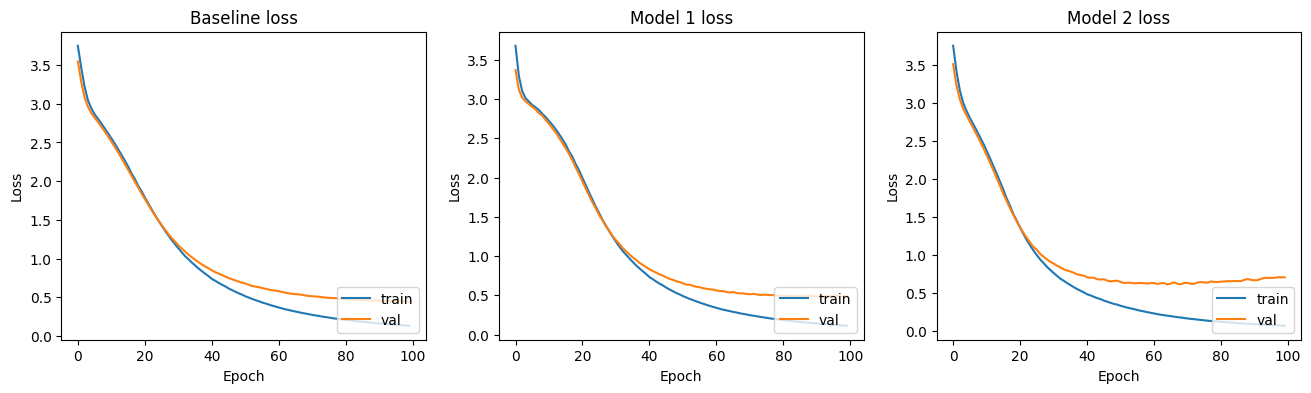

In [ ]:
# Loss
plt.figure(figsize=(16, 4))

# Baseline model
plt.subplot(1, 3, 1)
plt.plot(hist_baseline_model.history['loss'])
plt.plot(hist_baseline_model.history['val_loss'])
plt.title('Baseline loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc="lower right")

# Model 1
plt.subplot(1, 3, 2)
plt.plot(hist_model_1.history['loss'])
plt.plot(hist_model_1.history['val_loss'])
plt.title('Model 1 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc="lower right")

# Model 2
plt.subplot(1, 3, 3)
plt.plot(hist_model_2.history['loss'])
plt.plot(hist_model_2.history['val_loss'])
plt.title('Model 2 loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc="lower right")

plt.show()



These are the metrics on the validation set.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

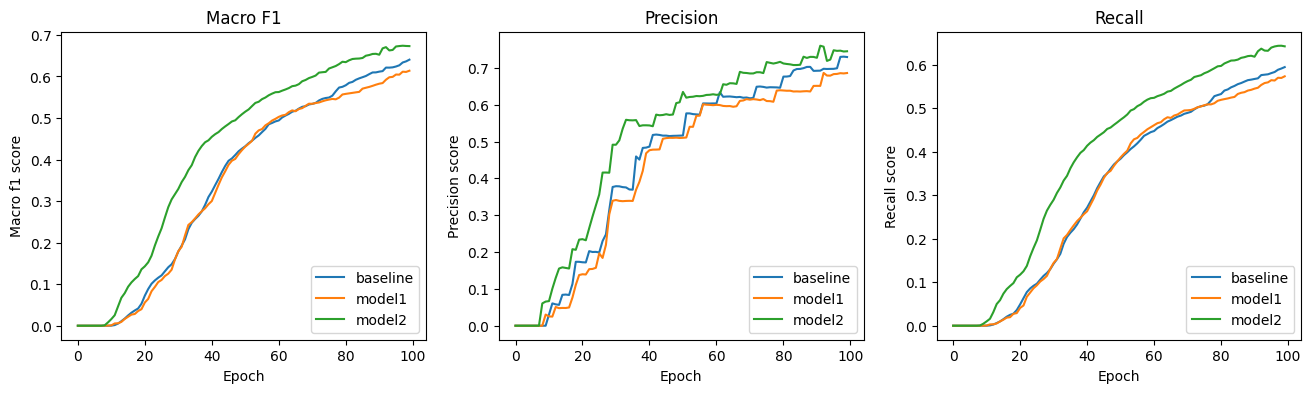

In [ ]:
plt.figure(figsize=(16, 4))

# Macro F1
plt.subplot(1, 3, 1)
plt.plot(metric_callback_baseline.f1_scores)
plt.plot(metric_callback_model_1.f1_scores)
plt.plot(metric_callback_model_2.f1_scores)
plt.title('Macro F1')
plt.ylabel('Macro f1 score')
plt.xlabel('Epoch')
plt.legend(['baseline', 'model1', 'model2'], loc="lower right")

# Precision
plt.subplot(1, 3, 2)
plt.plot(metric_callback_baseline.precision_scores)
plt.plot(metric_callback_model_1.precision_scores)
plt.plot(metric_callback_model_2.precision_scores)
plt.title('Precision')
plt.ylabel('Precision score')
plt.xlabel('Epoch')
plt.legend(['baseline', 'model1', 'model2'], loc="lower right")

# Recall
plt.subplot(1, 3, 3)
plt.plot(metric_callback_baseline.recall_scores)
plt.plot(metric_callback_model_1.recall_scores)
plt.plot(metric_callback_model_2.recall_scores)
plt.title('Recall')
plt.ylabel('Recall score')
plt.xlabel('Epoch')
plt.legend(['baseline', 'model1', 'model2'], loc="lower right")

plt.savefig("metrics.png")
files.download("metrics.png")

plt.show()

Now, we perform the evaluation on the validation and test set.

In [ ]:
def evalutate_val_test(model, tag_ids):
    # Val set
    Y_val_pred = np.round(model.predict(X_val))
    rows = Y_val_pred.shape[0] * Y_val_pred.shape[1]
    cols = Y_val_pred.shape[2]

    Y_val_reshaped = Y_val.reshape((rows, cols))
    Y_val_pred_reshaped = Y_val_pred.reshape((rows, cols))

    # Keep only tag ids and not other symbols
    Y_val_reshaped = Y_val_reshaped[:, tag_ids]
    Y_val_pred_reshaped = Y_val_pred_reshaped[:, tag_ids]

    f1 = f1_score(Y_val_reshaped, Y_val_pred_reshaped, average='macro', zero_division=0)
    pre = precision_score(Y_val_reshaped, Y_val_pred_reshaped, average='macro', zero_division=0)
    rec = recall_score(Y_val_reshaped, Y_val_pred_reshaped, average='macro', zero_division=0)
    print('Val set')
    print(f'f1: {f1:.3f}, precision: {pre:.3f}, recall: {rec:.3f}')
    print('-'*42)

    # Test set
    Y_test_pred = np.round(model.predict(X_test))
    rows = Y_test_pred.shape[0] * Y_test_pred.shape[1]
    cols = Y_test_pred.shape[2]

    Y_test_reshaped = Y_test.reshape((rows, cols))
    Y_test_pred_reshaped = Y_test_pred.reshape((rows, cols))

    # Keep only tag ids and not other symbols
    Y_test_reshaped = Y_test_reshaped[:, tag_ids]
    Y_test_pred_reshaped = Y_test_pred_reshaped[:, tag_ids]

    f1 = f1_score(Y_test_reshaped, Y_test_pred_reshaped, average='macro', zero_division=0)
    pre = precision_score(Y_test_reshaped, Y_test_pred_reshaped, average='macro', zero_division=0)
    rec = recall_score(Y_test_reshaped, Y_test_pred_reshaped, average='macro', zero_division=0)

    print('Test set')
    print(f'f1: {f1:.3f}, precision: {pre:.3f}, recall: {rec:.3f}')


In [ ]:
# Baseline
print('Baseline')
evalutate_val_test(baseline_model, label_ids)


Baseline
2/2 [==============================] - 0s 127ms/step
Val set
f1: 0.587, precision: 0.669, recall: 0.545
------------------------------------------
2/2 [==============================] - 0s 132ms/step
Test set
f1: 0.572, precision: 0.663, recall: 0.530


In [ ]:
# Model 1
print('Model 1 - Val/Test evaluation')
evalutate_val_test(model_1, label_ids)


Model 1 - Val/Test evaluation
2/2 [==============================] - 1s 244ms/step
Val set
f1: 0.563, precision: 0.629, recall: 0.526
------------------------------------------
2/2 [==============================] - 0s 241ms/step
Test set
f1: 0.559, precision: 0.623, recall: 0.521


In [ ]:
# Model 2
print('Model 2 - Val/Test evaluation')
evalutate_val_test(model_2, label_ids)


Model 2 - Val/Test evaluation
2/2 [==============================] - 0s 125ms/step
Val set
f1: 0.617, precision: 0.683, recall: 0.589
------------------------------------------
2/2 [==============================] - 0s 126ms/step
Test set
f1: 0.601, precision: 0.647, recall: 0.573


##🎈Task 6 - Error Analysis

We calculate the F1 score and other metrics for each label on the test set.

In [ ]:
def evalutate_per_tag(model, tag_ids):

    Y_test_pred = np.round(model.predict(X_test))
    rows = Y_test_pred.shape[0] * Y_test_pred.shape[1]
    cols = Y_test_pred.shape[2]

    Y_test_reshaped = Y_test.reshape((rows, cols))
    Y_test_pred_reshaped = Y_test_pred.reshape((rows, cols))

    # Keep only tag ids and not other symbols
    Y_test_reshaped = Y_test_reshaped[:, tag_ids]
    Y_test_pred_reshaped = Y_test_pred_reshaped[:, tag_ids]

    f1 = f1_score(Y_test_reshaped, Y_test_pred_reshaped, average=None, zero_division=0)
    pre = precision_score(Y_test_reshaped, Y_test_pred_reshaped, average=None, zero_division=0)
    rec = recall_score(Y_test_reshaped, Y_test_pred_reshaped, average=None, zero_division=0)

    ans = {'f1':f1, 'pre':pre, 'rec':rec}
    return ans


In [ ]:
ans_baseline = evalutate_per_tag(baseline_model, label_ids)


2/2 [==============================] - 0s 123ms/step


In [ ]:
ans_model_1 = evalutate_per_tag(model_1, label_ids)

2/2 [==============================] - 1s 260ms/step


In [ ]:
ans_model_2 = evalutate_per_tag(model_2, label_ids)

2/2 [==============================] - 0s 130ms/step


In [ ]:
def plot_metrics_per_tag(ans, model_name, tag_ids):

    # Filter out unwanted symbols
    all_tags = ['PAD'] + list(tag_tokenizer.word_index.keys())
    x_tag_list = [all_tags[i] for i in tag_ids]

    plt.figure(figsize=[12,3])
    plt.plot(x_tag_list, ans['f1'], marker='o', linestyle='--', color='blue', markersize=4, linewidth=0.5, alpha=0.7)
    plt.plot(x_tag_list, ans['pre'], marker='*', linestyle='--', color='green', markersize=4, linewidth=0.5, alpha=0.7)
    plt.plot(x_tag_list, ans['rec'], marker='s', linestyle='--', color='red', markersize=4, linewidth=0.5, alpha=0.7)
    plt.xlabel('Labels')
    plt.ylabel('Scores')
    plt.title(f'{model_name.capitalize()} - Metrics per label')
    plt.legend(['F1', 'P', 'R'])
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.show()

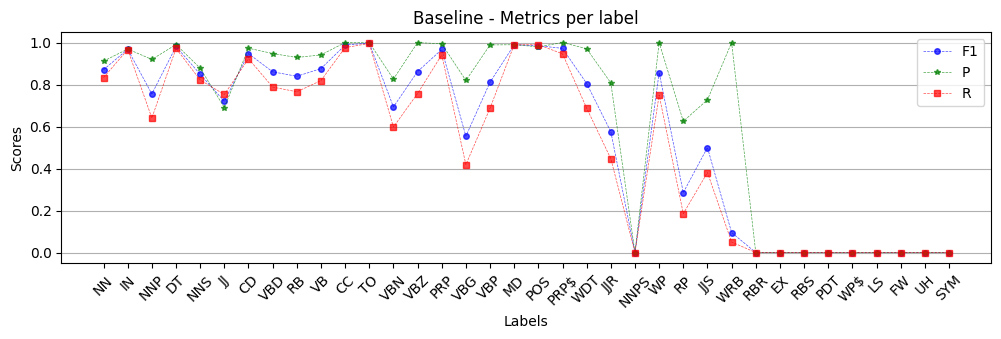

In [ ]:
plot_metrics_per_tag(ans_baseline, 'baseline', label_ids)

We can notice that the baseline has 0 score on the least frequent labels in the datasets - in the graph above, the labels starting from *RBR*. These tags are the most difficult to learn since they are very little in the training set; as a consequence, they pull down the F1 macro and other metrics.

**Note 1**: we have filtered out all the unwanted labels, such as class symbols and special characters. The graph above displays only the labels we are interested in, and on these we compute the metrics.

**Note 2**: regarding the rare labels, both the precision and recall is zero; as a consequence, the F1 is undefined (there is a zero at the denominator). In such cases, we set the F1 score to 0.

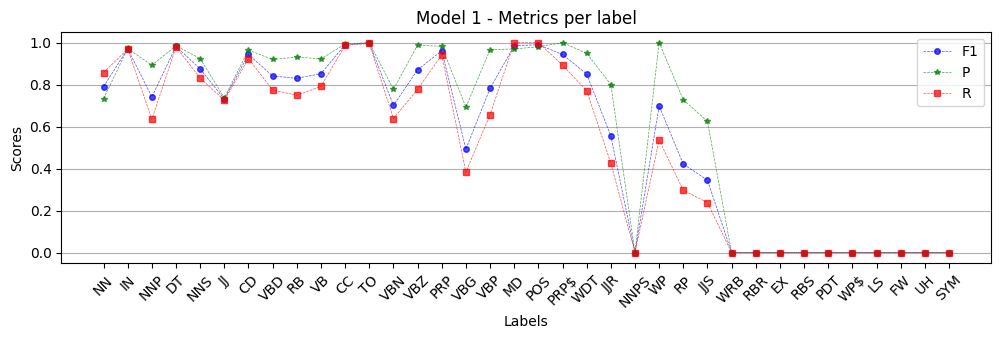

In [ ]:
plot_metrics_per_tag(ans_model_1, 'model 1', label_ids)

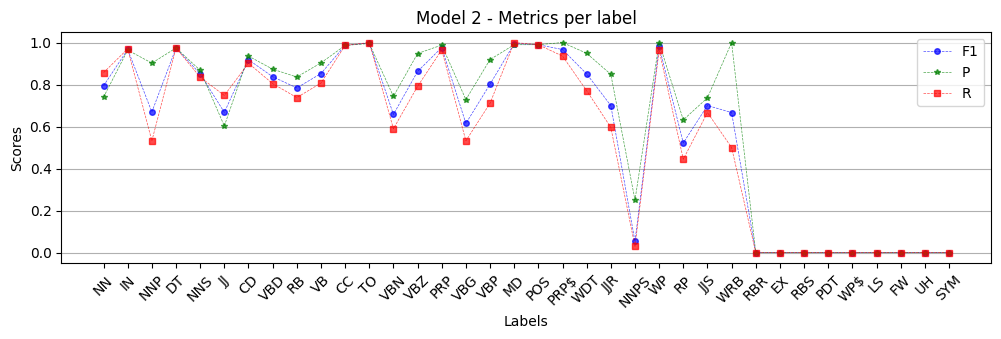

In [ ]:
plot_metrics_per_tag(ans_model_2, 'model 2', label_ids)

Comparisons between F1 scores and other metrics among the models.

In [ ]:
def plot_metric(metric_name):

    if metric_name == 'f1':
        metric = 'f1'
    elif metric_name == 'precision':
        metric = 'pre'
    elif metric_name == 'recall':
        metric = 'rec'
    else:
        print('Error: choose between f1, precision, and recall.')
        return

    # Filter out unwanted symbols
    all_tags = ['PAD'] + list(tag_tokenizer.word_index.keys())
    x_tag_list = [all_tags[i] for i in label_ids]

    plt.figure(figsize=[12,3])

    # Baseline
    #plt.plot(x_tag_list, ans_baseline[f'{metric}'], marker='o', linestyle='--', color='blue', markersize=4, linewidth=0.5, alpha=0.7)
    plt.fill_between(x_tag_list, ans_baseline[f'{metric}'], alpha=0.3)

    # Model 1
    plt.plot(x_tag_list, ans_model_1[f'{metric}'], marker='*', linestyle='--', color='green', markersize=4, linewidth=0.5, alpha=0.7)

    # Model 2
    plt.plot(x_tag_list, ans_model_2[f'{metric}'], marker='s', linestyle='--', color='red', markersize=4, linewidth=0.5, alpha=0.7)
    plt.xlabel('Labels')
    plt.ylabel('Scores')
    plt.title(f'{metric_name.capitalize()} scores for each model')
    plt.legend(['Baseline', 'Model 1', 'Model 2'])
    plt.grid(axis='y')
    plt.xticks(rotation=45)
    plt.savefig("plot.png")
    files.download("plot.png")
    plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

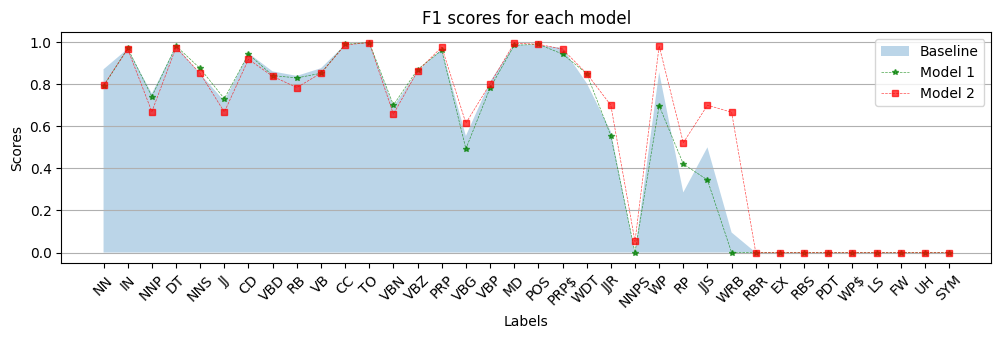

In [ ]:
plot_metric('f1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

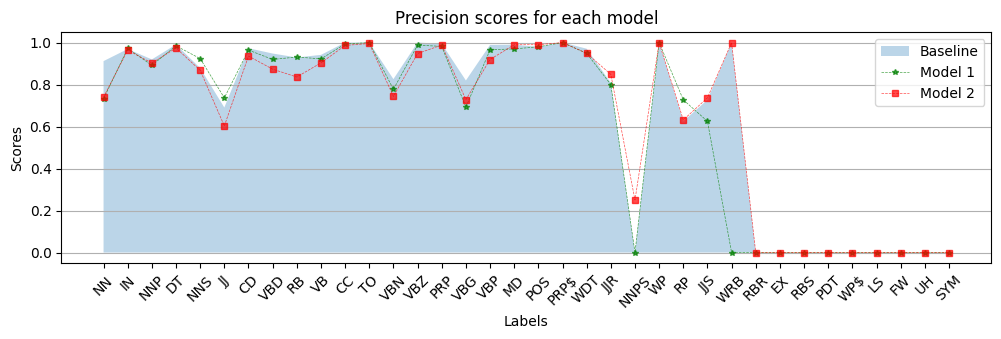

In [ ]:
plot_metric('precision')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

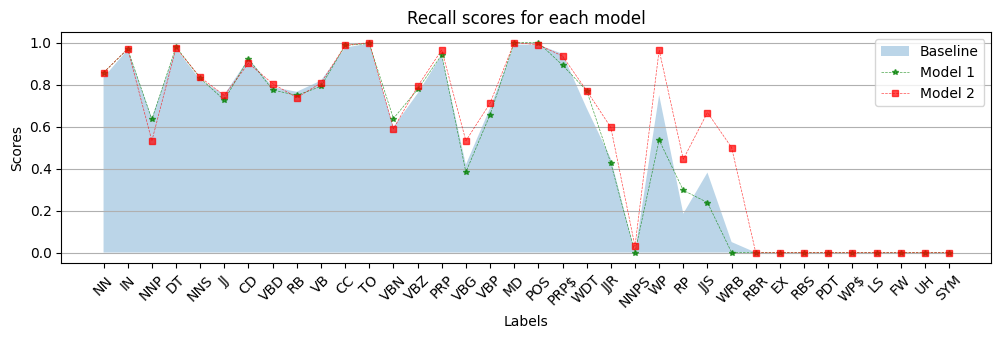

In [ ]:
plot_metric('recall')